In [3]:
from Bio import Entrez
import networkx as nx
import igraph as ig
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import combinations
from collections import defaultdict
import requests
import time
from tqdm import tqdm
from fuzzywuzzy import fuzz
import re
import unicodedata
from math import inf

import os
import sys

/home/jliem/.conda/envs/collab/lib/python3.13/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


# **Data Prep**

In [4]:
base_dir = 'data/psoriasis'
file_name = 'psoriasis.xlsx'
file_path = os.path.join(base_dir, file_name)

label_df = pd.read_excel(file_path, sheet_name='Labels')
dataset_df = pd.read_excel(file_path, sheet_name='Dataset')

In [5]:
print("Label Sheet:")
print(label_df.head())

print("\nDataset Sheet:")
print(dataset_df.tail())

Label Sheet:
  PMID: PubMed Identifier for indexed documents in Pubmed used for the study. PMIDs do not change over time or during processing and are never reused.
0           DP: Date that the article was published.                                                                                                  
1  FAU: Author name for articles published. From ...                                                                                                  
2  FAU-Revised: Author name after cleansing proce...                                                                                                  

Dataset Sheet:
            PMID    DP                        FAU            FAU-Revised
109275  23266843  2013      Augustin, Matthias, M     Augustin, Matthias
109276  23266843  2013  Rustenbach, Stephan J, SJ  Rustenbach, Stephan J
109277  23266843  2013     Beikert, Florian C, FC     Beikert, Florian C
109278  23558018  2013          Mattila, Kalle, K         Mattila, Kalle
10

# **Author ID Mapping**

In [6]:
# generate numerical identifier: I figured this out with LLM
dataset_df['author_id'] = dataset_df['FAU-Revised'].astype('category').cat.codes
author_df = dataset_df[['FAU-Revised', 'author_id']].drop_duplicates().reset_index(drop=True)
author_df = author_df.sort_values(by="author_id")
pmid_author_groups = dataset_df.groupby('PMID')['author_id'].apply(list)

# Create edge list by finding combinations of authors per paper
# https://docs.python.org/3/library/itertools.html
edges = set()
for author_list in pmid_author_groups:
    if len(author_list) > 1:
        for pair in combinations(sorted(set(author_list)), 2):
            edges.add(pair)

edge_df = pd.DataFrame(list(edges), columns=['source', 'target'])

print("Author ID Map:")
print(author_df.head())

Author ID Map:
          FAU-Revised  author_id
1508  ABDULLAEV, A Kh          0
1527       ABELE, D C          1
2205     ABELSON, N M          2
2265      ABRAHAMS, I          3
1920    ABRAMOVA, E I          4


# **Edge List**

In [7]:
edge_df = edge_df.merge(author_df, how='left', left_on='source', right_on='author_id')
edge_df = edge_df.rename(columns={'FAU-Revised': 'source_name'}).drop(columns=['author_id'])

# Merge to get target names
edge_df = edge_df.merge(author_df, how='left', left_on='target', right_on='author_id')
edge_df = edge_df.rename(columns={'FAU-Revised': 'target_name'}).drop(columns=['author_id'])
edge_df = edge_df[['source', 'source_name', 'target', 'target_name']]

print("\nEdge List with Author Names:")
print(edge_df.head())


Edge List with Author Names:
   source               source_name  target         target_name
0   16252               Gönlüşen, G   44038         Uzun, Soner
1    6327         Caloto, Ma Teresa   36473       Roset, Montse
2   25709                  Long, Li   45496       Wang, Shi-Yao
3    7197           Chan, Ting-Fung   46909          Xiao, Ming
4    4388  Blanco, Francisco Javier   14647  Giardina, Emiliano


# **Author/PMID Dict and Citation Extraction**

In [ ]:
#https://stackoverflow.com/questions/5900578/collections-defaultdict-difference-with-normal-dict
author_name_to_id = dict(zip(author_df['FAU-Revised'], author_df['author_id']))
author_id_to_pmids = defaultdict(list)

for idx, row in dataset_df.iterrows():
    author_name = row['FAU-Revised']
    pmid = row['PMID']

    if author_name in author_name_to_id:
        author_id = author_name_to_id[author_name]
        author_id_to_pmids[author_id].append(pmid)

# The dictionary of author id keys, PMIDs values
author_id_to_pmids = dict(author_id_to_pmids)

# PMID to authors
author_name_to_id = dict(zip(author_df['FAU-Revised'], author_df['author_id']))
pmid_to_authors = defaultdict(list)

for idx, row in dataset_df.iterrows():
    author_name = row['FAU-Revised']
    pmid = row['PMID']

    if author_name in author_name_to_id:
        author_id = author_name_to_id[author_name]
        pmid_to_authors[pmid].append(author_id)

pmid_to_authors = dict(pmid_to_authors)

In [ ]:
def get_icite_data(pmids):
    url = f"https://icite.od.nih.gov/api/pubs?pmids={','.join(map(str, pmids))}"
    response = requests.get(url)
    response.raise_for_status()
    data = response.json().get("data", [])
    return data

In [ ]:
# get all pmids
pmids = dataset_df['PMID'].unique()

api_batch_size = 1000

# batch by the limit for a given iCite API request
def batch_pmids(pmids, batch_size):
    for i in range(0, len(pmids), batch_size):
        yield pmids[i:i+batch_size]

# information we track on given authors that must be scraped
author_df["total_pubs"] = 0
author_df["total_citations"] = 0
author_df["avg_nih_percentile"] = 0.0
author_df["avg_relative_citation_ratio"] = 0.0

# iterate through PMIDS by batching and make requests
for pmid_batch in tqdm(batch_pmids(pmids, api_batch_size), total=len(pmids)//api_batch_size):
  icite_batch = get_icite_data(pmid_batch)
  for icite_entry in icite_batch:
    pmid = icite_entry["pmid"]
    authors = pmid_to_authors.get(pmid, [])
    relative_citation_ratio = icite_entry.get("relative_citation_ratio", 0)
    nih_percentile = icite_entry.get("nih_percentile", 0)
    citation_count = icite_entry.get("citation_count", 0)

    # increment number of publications and number of citations for those given authors
    for author_id in authors:
      author_df.loc[author_df["author_id"] == author_id, "total_pubs"] += 1
      author_df.loc[author_df["author_id"] == author_id, "total_citations"] += icite_entry["citation_count"]
      author_df.loc[author_df["author_id"] == author_id, "avg_nih_percentile"] += nih_percentile if nih_percentile is not None else 0
      author_df.loc[author_df["author_id"] == author_id, "avg_relative_citation_ratio"] += relative_citation_ratio if relative_citation_ratio is not None else 0

29it [07:24, 15.33s/it]


In [ ]:
author_df["avg_citations"] = author_df["total_citations"] / author_df["total_pubs"]
author_df["avg_nih_percentile"] = author_df["avg_nih_percentile"] / author_df["total_pubs"]
author_df["avg_relative_citation_ratio"] = author_df["avg_relative_citation_ratio"] / author_df["total_pubs"]

In [ ]:
author_df.tail(20)

,FAU-Revised,author_id,total_pubs,total_citations,avg_nih_percentile,avg_relative_citation_ratio,avg_citations
45926,"von Wurmb-Schwark, Nicole",48944,1,44,79.400000,2.370000,44.000000
14380,"von Wussow, P",48945,1,20,46.500000,0.910000,20.000000
23377,"von den Driesch, Peter",48946,2,192,73.950000,2.320000,96.000000
3732,"von der Lely, M A",48947,1,10,0.000000,0.730000,10.000000
43840,"Çekmen, M B",48948,1,42,66.000000,1.540000,42.000000
45472,"Çetiner, Salih",48949,1,11,26.600000,0.490000,11.000000
34061,"Östör, Andrew J K",48950,1,239,94.800000,5.980000,239.000000
48633,"Özdemir, Eda Çetin",48951,1,22,48.400000,0.950000,22.000000
35212,"Özdemir, Mustafa",48952,6,147,44.333333,1.101667,24.500000
43841,"Özdoğan, H K",48953,1,42,66.000000,1.540000,42.000000


# **Institutional Affiliations**

In [ ]:
def get_affiliation(pmids, target_authors, threshold, affiliations):
  Entrez.email = 'jliem@middlebury.edu'

  handle = Entrez.efetch(db="pubmed", id=','.join(pmids), rettype="xml")
  records = Entrez.read(handle)

  try:
    for i, article in enumerate(records["PubmedArticle"]):
      authors = article["MedlineCitation"]["Article"]["AuthorList"]

      for author in authors:
        full_name = f"{author.get('LastName', '')}, {author.get('ForeName', '')} {author.get('Initials', '')}".strip()
        affiliation = author.get("AffiliationInfo", [])


        match_score = fuzz.ratio(full_name.lower(), target_authors[i].lower())
        if match_score >= threshold:
          affiliations[target_authors[i]] = affiliation[0]['Affiliation'] if affiliation else None
    return affiliations

  except:
    return affiliations

{'Ayala, Fabio': None}


In [ ]:
# iterate through dataset_df pmids
affiliations = {}
req_size = 200
# iterate by 200 authors with tqdm
for i in tqdm(range(0, len(dataset_df), req_size)):
  pmids = dataset_df.iloc[i:i+req_size]["PMID"].tolist()
  pmids = list(map(str, pmids))
  target_authors = dataset_df.iloc[i:i+req_size]["FAU-Revised"].tolist()
  affiliations = get_affiliation(pmids, target_authors, 80, affiliations)

In [ ]:
# map by affiliations key to author_df
author_df["affiliation"] = author_df["FAU-Revised"].map(affiliations)
author_df[author_df["FAU-Revised"] == "Ayala, Fabio"]
print(len(author_df[author_df["affiliation"].notnull()]))
author_df[author_df["affiliation"].notnull()]

713
98


,FAU-Revised,author_id,total_pubs,total_citations,avg_nih_percentile,avg_relative_citation_ratio,avg_citations,n_collaborations,affiliation
506,"Ahmadi, Amrollah",506,1,7,14.000000,0.270000,7.000000,3,"Cancer Institute Research Center, Tehran Unive..."
749,"Alahlafi, Abdelaziz",749,1,55,71.800000,1.830000,55.000000,1,"Department of Dermatology, Churchill Hospital,..."
1005,"Almousa, Radwan",1005,1,2,4.700000,0.100000,2.000000,4,"Queen Victoria Hospital, West Sussex, UK."
1194,"Amirnia, Mehdi",1194,1,2,3.400000,0.070000,2.000000,3,"Sina Hospital, Tabriz University of Medical Sc..."
1671,"Arias-Santiago, Salvador",1671,8,261,44.662500,1.252500,32.625000,21,"Department of Dermatology, San Cecilio Univers..."
...,...,...,...,...,...,...,...,...,...
47946,"Zervou, Maria I",47946,3,65,26.100000,0.500000,21.666667,6,"Laboratory of Dermatology, Department of Medic..."
48068,"Zhang, Xue-Jun",48068,38,1975,40.410526,1.256842,51.973684,266,"Key Laboratory of Genome Research at Anhui, In..."
48229,"Zhu, Kun-Ju",48229,13,674,44.692308,1.357692,51.846154,90,"Department of Dermatology, Affiliated Hospital..."
48247,"Zhu, Y W",48247,1,22,33.000000,0.610000,22.000000,4,"Pharmacokinetics, Modeling and Simulation, Bio..."


# **First Author Status**

In [ ]:
def normalize_name(name):
    # Remove punctuation except commas
    name = re.sub(r'[^\w\s,]', '', name)

    # Remove accents
    name = unicodedata.normalize('NFD', name)
    name = ''.join(char for char in name if unicodedata.category(char) != 'Mn')

    name = name.upper().strip()

    if ',' in name:
        last, rest = [part.strip() for part in name.split(',', 1)]
        first_initial = rest.split()[0][0] if rest else ''
        return f"{last} {first_initial}"

    else:
        parts = name.split()
        if len(parts) >= 2:
            # All but last = last name, last = initial
            last_name = ' '.join(parts[:-1])
            first_initial = parts[-1][0]
            return f"{last_name} {first_initial}"
        return name

def name_match(query_name, full_name, threshold=50):
    norm_query = normalize_name(query_name)
    norm_full = normalize_name(full_name)
    return fuzz.ratio(norm_query, norm_full) >= threshold

def get_author_status(pmids, target_authors, first_author_counts, last_author_counts, single_author_counts, missing_author_counts):
    base_url = "https://www.ebi.ac.uk/europepmc/webservices/rest/search"

    # Build query
    query = " OR ".join([f"EXT_ID:{pmid}" for pmid in pmids])
    params = {
        "query": f"({query})",
        "format": "json",
        "pageSize": len(pmids)
    }

    try:
        response = requests.get(base_url, params=params)
        response.raise_for_status()
        data = response.json()
        results = data.get("resultList", {}).get("result", [])
    except Exception:
        results = []

    # Map results by PMID
    pmid_to_result = {r.get("pmid"): r for r in results}

    for pmid, query_name in zip(pmids, target_authors):
        article = pmid_to_result.get(pmid)

        if not article:
            print(f"No result found for PMID: {pmid}")
            missing_author_counts[query_name] = missing_author_counts.get(query_name, 0) + 1
            continue

        author_string = article.get("authorString", "")
        if not author_string:
            print(f"No authors found for PMID: {pmid}")
            missing_author_counts[query_name] = missing_author_counts.get(query_name, 0) + 1
            continue

        # Split author string on commas
        authors = [a.strip() for a in author_string.split(",") if a.strip()]
        matched = False

        for j, full_name in enumerate(authors):
             if name_match(query_name, full_name):
                if j == 0:
                    first_author_counts[query_name] = first_author_counts.get(query_name, 0) + 1
                    last_author_counts[query_name] = last_author_counts.get(query_name, 0)
                    single_author_counts[query_name] = single_author_counts.get(query_name, 0)
                    missing_author_counts[query_name] = missing_author_counts.get(query_name, 0)
                if j == len(authors) - 1:
                    last_author_counts[query_name] = last_author_counts.get(query_name, 0) + 1
                    first_author_counts[query_name] = first_author_counts.get(query_name, 0)
                    single_author_counts[query_name] = single_author_counts.get(query_name, 0)
                    missing_author_counts[query_name] = missing_author_counts.get(query_name, 0)
                if len(authors) == 1:
                    single_author_counts[query_name] = single_author_counts.get(query_name, 0) + 1
                    first_author_counts[query_name] = first_author_counts.get(query_name, 0)
                    last_author_counts[query_name] = last_author_counts.get(query_name, 0)
                    missing_author_counts[query_name] = missing_author_counts.get(query_name, 0)
                matched = True
                break

        if not matched:
            first_author_counts.setdefault(query_name, 0)
            last_author_counts.setdefault(query_name, 0)
            single_author_counts.setdefault(query_name, 0)
            missing_author_counts.setdefault(query_name, 0)

            assert query_name in first_author_counts
            assert query_name in last_author_counts

    return first_author_counts, last_author_counts, single_author_counts, missing_author_counts

In [ ]:
first_author_counts = {}
last_author_counts = {}
single_author_counts = {}
missing_author_counts = {}
req_size = 200

for i in tqdm(range(0, len(dataset_df), req_size)):
    chunk = dataset_df.iloc[i:i+req_size]
    pmids = list(map(str, chunk["PMID"].tolist()))
    target_authors = chunk["FAU-Revised"].tolist()
    first_author_counts, last_author_counts, single_author_counts, missing_author_counts = get_author_status(pmids,
                                                                                                            target_authors,
                                                                                                            first_author_counts,
                                                                                                            last_author_counts,
                                                                                                            single_author_counts,
                                                                                                            missing_author_counts)

print("First author counts:", first_author_counts)
print("Last author counts:", last_author_counts)
print("Single author counts:", single_author_counts)
print("Missing author counts:", missing_author_counts)

In [ ]:
print(len(first_author_counts))
print(len(last_author_counts))

# map first author and last author to corresponding author in author_df
# set all first and last author to default 0
author_df["n_first_author"] = 0
author_df["n_last_author"] = 0
author_df["n_single_author"] = 0
author_df["n_missing_author"] = 0

author_df["n_first_author"] = author_df["FAU-Revised"].map(first_author_counts)
author_df["n_last_author"] = author_df["FAU-Revised"].map(last_author_counts)
author_df["n_single_author"] = author_df["FAU-Revised"].map(single_author_counts)
author_df["n_missing_author"] = author_df["FAU-Revised"].map(missing_author_counts)

26116
26116


In [ ]:
author_df

,FAU-Revised,author_id,total_pubs,total_citations,avg_nih_percentile,avg_relative_citation_ratio,avg_citations,n_collaborations,affiliation,n_first_author,n_last_author,n_single_author,n_missing_author
0,"ABDULLAEV, A Kh",0,1,0,0.000,0.0000,0.00,0,NaN,1.0,1.0,1.0,0.0
1,"ABELE, D C",1,1,81,0.000,0.6600,81.00,2,NaN,1.0,0.0,0.0,0.0
2,"ABELSON, N M",2,1,102,0.000,2.3100,102.00,2,NaN,1.0,0.0,0.0,0.0
3,"ABRAHAMS, I",3,1,1,0.000,0.0500,1.00,0,NaN,1.0,1.0,1.0,0.0
4,"ABRAMOVA, E I",4,1,0,0.000,0.0000,0.00,2,NaN,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
48959,"Ćalasan, Maja Bulatović",48959,1,60,81.600,2.5900,60.00,6,NaN,1.0,0.0,0.0,0.0
48960,"Şenyurt, Süleyman Ziya",48960,1,22,48.400,0.9500,22.00,8,NaN,NaN,NaN,NaN,NaN
48961,"Šipek-Dolnicar, Alenka",48961,1,47,70.500,1.7600,47.00,6,NaN,NaN,NaN,NaN,NaN
48962,"Štolfa, Jiří",48962,4,71,28.375,0.6425,17.75,16,NaN,1.0,0.0,0.0,0.0


Error: Runtime no longer has a reference to this dataframe, please re-run this cell and try again.


# **Saving Formatted Data**

In [ ]:
# save author_id_map to file and edge df
author_df.to_csv("drive/MyDrive/Semester 8/CS0442/author_df.csv", index=False)
edge_df.to_csv("drive/MyDrive/Semester 8/CS0442/edge_df.csv", index=False)

# **iGraph Testing**

In [59]:
author_df = pd.read_csv("data/psoriasis/author_df.csv")
edge_df = pd.read_csv("data/psoriasis/edge_df.csv")

In [62]:
n_edges = len(edge_df)
print(f"Number of edges: {n_edges}")

all_nodes = list(author_df['author_id'])
node_names = list(author_df['FAU-Revised'])
edges = list(edge_df[['source', 'target']].itertuples(index=False, name=None))

Number of edges: 211540


In [ ]:
g = ig.Graph()
g.add_vertices(len(all_nodes))
g.vs['id'] = all_nodes
g.vs['name'] = node_names
g.add_edges(edges)

In [ ]:
author_df.tail(100)

,FAU-Revised,author_id,total_pubs,total_citations,avg_nih_percentile,avg_relative_citation_ratio,avg_citations,n_collaborations,affiliation,n_first_author,n_last_author,n_single_author,n_missing_author
48864,"van der Horst-Bruinsma, Irene E",48864,2,311,72.20,4.12,155.50,4,NaN,1.0,0.0,0.0,0.0
48865,"van der Jeught, J",48865,1,0,0.00,0.00,0.00,6,NaN,NaN,NaN,NaN,NaN
48866,"van der Kamp, A W",48866,1,6,13.80,0.27,6.00,7,NaN,NaN,NaN,NaN,NaN
48867,"van der Kerkhof, Peter C M",48867,2,53,38.25,0.82,26.50,9,NaN,1.0,0.0,0.0,0.0
48868,"van der Kleij, Desiree",48868,1,84,83.60,2.81,84.00,2,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
48959,"Ćalasan, Maja Bulatović",48959,1,60,81.60,2.59,60.00,6,NaN,1.0,0.0,0.0,0.0
48960,"Şenyurt, Süleyman Ziya",48960,1,22,48.40,0.95,22.00,8,NaN,NaN,NaN,NaN,NaN
48961,"Šipek-Dolnicar, Alenka",48961,1,47,70.50,1.76,47.00,6,NaN,NaN,NaN,NaN,NaN
48962,"Štolfa, Jiří",48962,4,71,28.38,0.64,17.75,16,NaN,1.0,0.0,0.0,0.0


Most psoriasis researchers with publications seem to be individual contributors who do not collaborate with anyone.

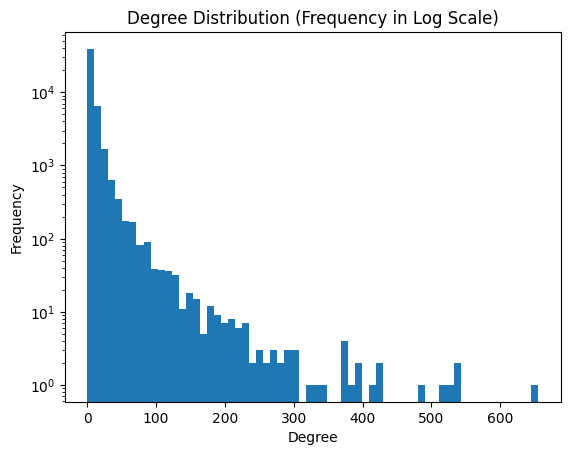

In [ ]:
K = g.degree()

plt.hist(K, bins=64)
plt.yscale("log")
plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.title('Degree Distribution (Frequency in Log Scale)')
plt.show()

In [ ]:
# get n highest degrees
top_n = 10
sorted_ids = sorted(range(len(K)), key=lambda i: K[i], reverse=True)
top_n_ids = sorted_ids[:top_n]
top_collaborators = author_df[author_df["author_id"].isin(top_n_ids)]
top_collaborators

,FAU-Revised,author_id,total_pubs,total_citations,avg_nih_percentile,avg_relative_citation_ratio,avg_citations,n_collaborations,affiliation,n_first_author,n_last_author,n_single_author,n_missing_author
2909,"Barker, Jonathan N W N",2909,130,14986,57.37,3.06,115.28,539,NaN,24.0,42.0,8.0,0.0
11448,"Elder, James T",11448,94,11711,60.53,3.00,124.59,396,NaN,21.0,26.0,6.0,3.0
14871,"Gladman, Dafna D",14871,246,26074,60.37,3.11,105.99,539,NaN,106.0,62.0,26.0,0.0
15341,"Gottlieb, Alice B",15341,188,21321,61.72,3.17,113.41,531,NaN,67.0,60.0,13.0,1.0
15634,"Griffiths, Christopher E M",15634,240,24108,58.13,2.96,100.45,655,NaN,36.0,99.0,9.0,3.0
22990,"Krueger, Gerald G",22990,127,16389,58.24,3.47,129.05,425,NaN,30.0,29.0,7.0,1.0
24294,"Lebwohl, Mark G",24294,174,16042,55.29,2.78,92.20,413,NaN,60.0,70.0,19.0,0.0
28405,"Menter, Alan",28405,167,20335,61.93,3.48,121.77,485,"Baylor University Medical Center, Dallas, Texa...",56.0,42.0,12.0,0.0
44295,"Van de Kerkhof, Peter C M",44295,355,13189,39.88,1.24,37.15,512,NaN,113.0,101.0,32.0,0.0
44999,"Voorhees, John J",44999,210,14946,46.92,2.21,71.17,426,NaN,21.0,113.0,5.0,5.0


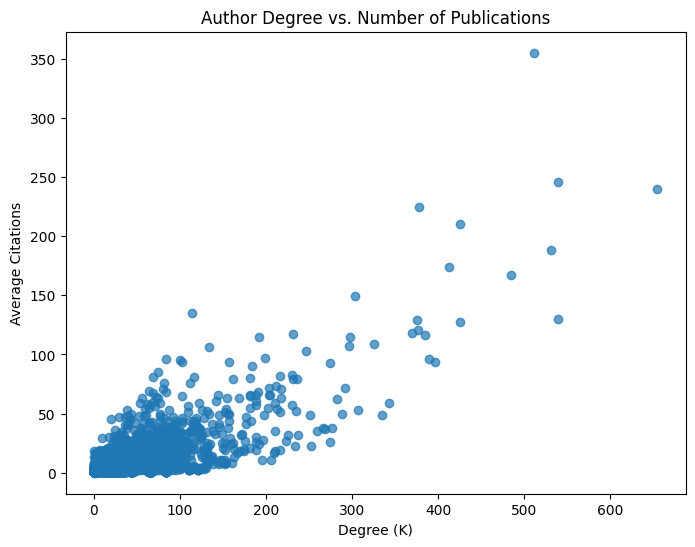

In [ ]:
# plot a scatter plot of degree vs avg citations
plt.figure(figsize=(8, 6))
plt.scatter(K, author_df['total_pubs'], alpha=0.7)
plt.xlabel('Degree (K)')
plt.ylabel('Average Citations')
plt.title('Author Degree vs. Number of Publications')
plt.show()

# **Weighted Graphs**

In [2]:
import networkx as nx
import igraph as ig
from igraph import *
import numpy as np
from itertools import combinations
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import kendalltau, spearmanr
from collections import defaultdict
import scipy.stats as stats
import statistics
import tqdm
import seaborn as sns

import os
import sys

In [10]:
base_dir = 'data/psoriasis'
file_name = 'psoriasis.xlsx'
file_path = os.path.join(base_dir, file_name)

label_df = pd.read_excel(file_path, sheet_name='Labels')
dataset_df = pd.read_excel(file_path, sheet_name='Dataset')

In [11]:
print("Label Sheet:")
print(label_df.head())

print("\nDataset Sheet:")
print(dataset_df.tail())

Label Sheet:
  PMID: PubMed Identifier for indexed documents in Pubmed used for the study. PMIDs do not change over time or during processing and are never reused.
0           DP: Date that the article was published.                                                                                                  
1  FAU: Author name for articles published. From ...                                                                                                  
2  FAU-Revised: Author name after cleansing proce...                                                                                                  

Dataset Sheet:
            PMID    DP                        FAU            FAU-Revised
109275  23266843  2013      Augustin, Matthias, M     Augustin, Matthias
109276  23266843  2013  Rustenbach, Stephan J, SJ  Rustenbach, Stephan J
109277  23266843  2013     Beikert, Florian C, FC     Beikert, Florian C
109278  23558018  2013          Mattila, Kalle, K         Mattila, Kalle
10

In [12]:
# generate numerical identifier: I figured this out with LLM
dataset_df['author_id'] = dataset_df['FAU-Revised'].astype('category').cat.codes
author_df = dataset_df[['FAU-Revised', 'author_id']].drop_duplicates().reset_index(drop=True)
author_df = author_df.sort_values(by="author_id")

# group authors for given paper
# https://docs.python.org/3/library/collections.html
pmid_author_groups = dataset_df.groupby('PMID')['author_id'].apply(list)
weighted_edges = defaultdict(float)

# Iterate through the author lists for each paper and unique pairs of those authors
# https://docs.python.org/3/library/itertools.html
for author_list in pmid_author_groups:
    if len(author_list) > 1:
        for pair in combinations(sorted(set(author_list)), 2):
            weighted_edges[pair] += 1

# Weighted edges to pandas DF: SEE https://stackoverflow.com/questions/44012099/creating-a-dataframe-from-a-dict-where-keys-are-tuples
index = pd.MultiIndex.from_tuples(weighted_edges.keys(), names=['source', 'target'])
weights = pd.Series(weighted_edges.values(), index=index, name='weight')
weighted_edge_df = weights.reset_index()
weighted_edge_df.to_csv("data/psoriasis/weighted_edge_df.csv", index=False)

# **Scrape Citation Information and Generate Citation Network Dataframes**

In [93]:
import requests
from typing import Dict, List
from collections import defaultdict
import time
import random
import networkx as nx
import igraph as ig
from igraph import *
import numpy as np
from itertools import combinations
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import kendalltau, spearmanr
from collections import defaultdict
import scipy.stats as stats
import statistics
import json
from tqdm import tqdm
import seaborn as sns
import pickle

import os
import sys

In [94]:
base_dir = 'data/psoriasis'
file_name = 'psoriasis.xlsx'
file_path = os.path.join(base_dir, file_name)

label_df = pd.read_excel(file_path, sheet_name='Labels')
paper_df = pd.read_excel(file_path, sheet_name='Dataset')

In [95]:
paper_df = paper_df[paper_df['DP'] >= 1992].reset_index(drop=True)
paper_df['author_id'] = paper_df['FAU-Revised'].astype('category').cat.codes

if 'FAU' in paper_df.columns:
    paper_df = paper_df.drop("FAU", axis=1)

paper_df = paper_df.groupby('PMID').agg({
    'author_id': lambda x: list(dict.fromkeys(x)),
    'FAU-Revised': lambda x: list(dict.fromkeys(x)),
    'DP': 'first'}).reset_index()

# Create mapping and list of PMIDs
pmid_author_groups = paper_df.set_index('PMID')['author_id'].to_dict()
pmids = list(pmid_author_groups.keys())

In [96]:
def get_icite_data(pmids):
    failed_pmids = []
    data = []

    try:
        url = f"https://icite.od.nih.gov/api/pubs?pmids={','.join(map(str, pmids))}"
        response = requests.get(url)
        response.raise_for_status()
        data = response.json().get("data", [])
        returned_pmids = {str(item.get("pmid")) for item in data}
        input_pmids = {str(pmid) for pmid in pmids}
        failed_pmids = list(input_pmids - returned_pmids)

    except Exception as e:
        print(f"Request failed for {len(pmids)} PMIDs: {e}")
        failed_pmids = pmids

    if failed_pmids:
        print(f"{len(failed_pmids)} PMIDs failed:")
        print(failed_pmids)

    return data

data = get_icite_data(pmids[0:2])
print(data[0]["cited_by"])
print(data[1]["cited_by"])
print(data[1])

# both should contain only authors 1992 and after for citations
# . batch by 200 over pmids
# . generate dictionary of pmid: "cited_by" pmids
# . generate edge pairs df of citing paper and cted paper
# . save edge dataframe as citation_edge_df
# . save list of unique pmids as citation_paper_df

# . cross-reference keys and values against author_df to generate edges from citing author to cited author
# . save edges as citation_edge_df
# . save authors as citation_author_df

[22567008, 22313597, 15140223, 20594411]
[19659772, 19268507, 15513559, 36970858, 38875993, 21865680]
{'pmid': 1280904, 'year': 1992, 'title': 'Focus tonsils and skin diseases with special reference to palmoplantar pustulosis.', 'authors': 'K Kuki, T Kimura, Y Hayashi, T Tabata', 'journal': 'Adv Otorhinolaryngol', 'is_research_article': 'Yes', 'relative_citation_ratio': 0.31, 'nih_percentile': 16.1, 'human': 1.0, 'animal': 0.0, 'molecular_cellular': 0.0, 'apt': 0.05, 'is_clinical': 'No', 'citation_count': 6, 'citations_per_year': 0.18181818181818182, 'expected_citations_per_year': 0.5960359276569618, 'field_citation_rate': 2.404700334054248, 'provisional': 'No', 'x_coord': 0.0, 'y_coord': 1.0, 'cited_by_clin': [38875993], 'cited_by': [19659772, 19268507, 15513559, 36970858, 38875993, 21865680], 'references': [], 'doi': '10.1159/000421744', 'last_modified': '04/27/2025, 05:59:10'}


In [97]:
def batch_pmids(pmids, batch_size):
    for i in range(0, len(pmids), batch_size):
        yield pmids[i:i+batch_size]

In [98]:
api_batch_size = 150
cited_by = {}
references = {}
paper_df['title'] = ''
paper_df['authors'] = ''
paper_df['journal'] = ''
paper_df['is_research_article'] = ''
paper_df['last_modified'] = ''
paper_df['n_ref'] = 0
paper_df['n_cited_by'] = 0
paper_df['citations_per_year'] = 0.0
paper_df['expected_citations_per_year'] = 0.0
paper_df['apt'] = 0.0
paper_df['field_citation_rate'] = 0.0
paper_df['rcr'] = 0.0
paper_df['doi'] = ''
paper_df['nih_percentile'] = 0.0
paper_df['human'] = 0.0
paper_df['animal'] = 0.0
paper_df['molecular_cellular'] = 0.0

for pmid_batch in tqdm(batch_pmids(pmids, api_batch_size), total=len(pmids)//api_batch_size):
  icite_batch = get_icite_data(pmid_batch)
  for icite_entry in icite_batch:
    pmid = icite_entry["pmid"]
    cited_by[pmid] = icite_entry['cited_by']
    references[pmid] = icite_entry['references']
    paper_df.loc[paper_df["PMID"]==pmid, "title"] = icite_entry['title']
    paper_df.loc[paper_df["PMID"]==pmid, "authors"] = icite_entry['authors']
    paper_df.loc[paper_df["PMID"]==pmid, "is_research_article"] = icite_entry['is_research_article']
    paper_df.loc[paper_df["PMID"]==pmid, "n_ref"] = len(icite_entry['references'])
    paper_df.loc[paper_df["PMID"]==pmid, "n_cited_by"] = len(icite_entry['cited_by'])
    paper_df.loc[paper_df["PMID"]==pmid, "citations_per_year"] = icite_entry['citations_per_year']
    paper_df.loc[paper_df["PMID"]==pmid, "expected_citations_per_year"] = icite_entry['expected_citations_per_year']
    paper_df.loc[paper_df["PMID"]==pmid, "field_citation_rate"] = icite_entry['field_citation_rate']
    paper_df.loc[paper_df["PMID"]==pmid, "rcr"] = icite_entry['relative_citation_ratio']
    paper_df.loc[paper_df["PMID"]==pmid, "doi"] = icite_entry['doi']
    paper_df.loc[paper_df["PMID"]==pmid, "last_modified"] = icite_entry['last_modified']
    paper_df.loc[paper_df["PMID"]==pmid, "nih_percentile"] = icite_entry['nih_percentile']
    paper_df.loc[paper_df["PMID"]==pmid, "journal"] = icite_entry['journal']
    paper_df.loc[paper_df["PMID"]==pmid, "human"] = icite_entry['human']
    paper_df.loc[paper_df["PMID"]==pmid, "animal"] = icite_entry['animal']
    paper_df.loc[paper_df["PMID"]==pmid, "molecular_cellular"] = icite_entry['molecular_cellular']
    paper_df.loc[paper_df["PMID"]==pmid, "apt"] = icite_entry['apt']

  0%|          | 0/106 [00:00<?, ?it/s]

1 PMIDs failed:
['1345156']


107it [02:33,  1.44s/it]                         


In [99]:
citation_pairs = []
for pmid, citing_pmids in tqdm(cited_by.items(), total=len(cited_by)):
    citation_pairs.extend((pmid, citing_pmid) for citing_pmid in citing_pmids)
paper_citation_df = pd.DataFrame(citation_pairs, columns=['cited', 'citing'])

100%|██████████| 16029/16029 [00:00<00:00, 193293.85it/s]


In [100]:
num_pmids_in_cited = len(set(pmids).intersection(paper_citation_df['cited']))
num_pmids_in_citing = len(set(pmids).intersection(paper_citation_df['citing']))

prop_cited = num_pmids_in_cited / len(pmids)
prop_citing = num_pmids_in_citing / len(pmids)

print(f"Proportion of original psoriasis pmids appearing in the cited pmids: {prop_cited:.2f}")
print(f"Proportion of original psoriasis pmids that cite other pmids: {prop_citing:.2f}")

# PLEASE NOTE THAT THERE APPEARS TO BE A BIAS IN A SMALL MINORITY OF CASES (APPROXIMATELY 7%) WHERE 
# WE SUSPECT MAJOR NIH/NCBI/PUBMED DATABASES DO NOT STORE OR HOLD MUCH INFORMATION ON PAPERS PREDOMINANTLY
# WRITTEN BY INTERNATIONAL AUTHORS AND OTHER LANGUAGES AND THEIR LEVELS OF CITEDNESS.
# WHILE THIS MAY BE AN INHERENT PROPERTY OF LIMITED RECOGNITION FOR CERTAIN RESEARCHERS ABROAD, IT MAY
# ALSO REFLECT LACK OF DATABASE TRACKING OF RESEARCH THAT IS NOT CENTERED AROUND THE US/MAJOR WESTERN COUNTRIES
# INVOLVED FOR PSORIASIS WORK

Proportion of original psoriasis pmids appearing in the cited pmids: 0.93
Proportion of original psoriasis pmids that cite other pmids: 0.76


In [117]:
paper_df

,PMID,author_id,FAU-Revised,DP,title,authors,journal,is_research_article,last_modified,n_ref,...,citations_per_year,expected_citations_per_year,apt,field_citation_rate,rcr,doi,nih_percentile,human,animal,molecular_cellular
0,1280069,"[15264, 22485]","[Kawashima, Makoto, Nogita, T]",1992,Increased levels of plasma vitronectin in seve...,"T Nogita, M Kawashima",Arch Dermatol Res,Yes,"04/27/2025, 05:59:08",12,...,0.121212,0.976159,0.05,4.683341,0.12,10.1007/BF00372589,6.0,1.00,0.0,0.00
1,1280904,"[16723, 15764, 12364, 30153]","[Kuki, K, Kimura, T, Hayashi, Yasuhiro, Tabata...",1992,Focus tonsils and skin diseases with special r...,"K Kuki, T Kimura, Y Hayashi, T Tabata",Adv Otorhinolaryngol,Yes,"04/27/2025, 05:59:10",0,...,0.181818,0.596036,0.05,2.404700,0.31,10.1159/000421744,16.1,1.00,0.0,0.00
2,1281074,"[13458, 11116]","[Husby, G, Gran, Jan Tore]",1992,Ankylosing spondylitis. Current drug treatment.,"J T Gran, G Husby",Drugs,Yes,"04/27/2025, 05:59:10",124,...,0.454545,0.696589,0.25,3.007464,0.65,10.2165/00003495-199244040-00006,35.1,0.00,1.0,0.00
3,1284104,"[9611, 11967]","[Fransson, J, Hammar, H]",1992,Epidermal growth in the skin equivalent.,"J Fransson, H Hammar",Arch Dermatol Res,Yes,"04/27/2025, 05:59:17",24,...,0.545455,0.695516,0.25,3.001032,0.78,10.1007/BF00372037,41.4,0.57,0.0,0.43
4,1284133,"[24773, 18570, 26415, 4832, 19070, 27004, 3347...","[Portioli, I, Lodi, L, Rossi, F, Casadei-Maldi...",1992,Immunologic effects in patients with psoriatic...,"L Boiardi, C Salvarani, P Macchioni, M Casadei...",J Rheumatol,Yes,"04/27/2025, 05:59:17",29,...,0.272727,0.674121,0.25,2.872779,0.40,,21.8,0.20,0.0,0.80
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16025,24701255,"[24744, 3358, 13789, 35155]","[Popescu, C M, Bojincă, V, Ionescu, R, Zofotă, S]",2013,Anti-cyclic citrullinated peptide antibodies i...,"C Popescu, S Zofotă, V Bojincă, R Ionescu",J Med Life,No,"04/27/2025, 05:30:22",27,...,1.500000,2.054959,0.50,4.578089,0.73,,38.8,1.00,0.0,0.00
16026,24800428,"[11594, 12751, 4296, 21616]","[Gupta, Rishu, High, Whitney A, Butler, Daniel...",2013,Medicolegal aspects of prescribing dermatologi...,"Rishu Gupta, Whitney A High, Daniel Butler, Je...",Semin Cutan Med Surg,Yes,"04/27/2025, 05:30:33",42,...,0.250000,1.919120,0.05,4.116465,0.13,10.12788/j.sder.0034,6.4,1.00,0.0,0.00
16027,24974491,"[15053, 28456, 15515, 8905, 5164, 19288, 7345]","[Karoli, Ritu, Shukla, Vaibhav, Khanduri, Sach...",2013,A study of cardio-metabolic risk profile in pa...,"Ritu Karoli, Jalees Fatima, Vaibhav Shukla, K ...",J Assoc Physicians India,Yes,"04/27/2025, 05:30:46",0,...,1.250000,1.762211,0.50,3.583241,0.71,,37.9,1.00,0.0,0.00
16028,25016757,[1701],"[Babanin, V A]",2013,[Mechanisms of immune suppression of systemic ...,V A Babanin,Lik Sprava,Yes,"04/27/2025, 05:30:49",0,...,0.000000,NaN,0.05,NaN,0.00,,0.0,0.50,0.0,0.50


## Save Data

In [111]:
paper_df.to_csv("data/psoriasis/citation_paper_df.csv", index=False)
paper_citation_df.to_csv("data/psoriasis/citation_paper_edge_df.csv", index=False)